In [1]:
## Installing corresponding python packages
# !pip install openai pyarrow pandas pillow matplotlib

## accessing the api_key of qwen model following the below link
# https://help.aliyun.com/zh/model-studio/get-api-key

# data loading

In [2]:
import os
import re
import json
import random
from openai import OpenAI
from base_prompt import *

import pyarrow.parquet as pq
import pandas as pd
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

import copy

random.seed(42)

In [3]:
def load_data(data_root='data/scienceqa_json/', test_number=10, shot_number=3):
    print(f"loading data {'*'*50}")
    problems = json.load(open(f"{data_root}problems.json"))
    pid_splits = json.load(open(f"{data_root}pid_splits.json"))
    captions = json.load(open(f"{data_root}instruct_captions.json"))["captions"]

    for qid in problems:
        problems[qid]['caption'] = captions[qid] if qid in captions else ""

    qids = pid_splits['test']
    qids = qids[:test_number] if test_number > 0 else qids
    print(f"number of test problems: {len(qids)}")

    # pick up shot examples from the training set
    train_qids = pid_splits['train']
    shot_qids = random.sample(train_qids, shot_number)  # random sample
    print(f"training question ids for prompting: {shot_qids}")
    
    return problems, qids, shot_qids

def visualize_qestion_img(q_idx, img_caption):
    parquet_path = 'data/scienceqa_parquet/test-00000-of-00001-f0e719df791966ff.parquet'
    parquet_file = pq.ParquetFile(parquet_path)
    data = parquet_file.read().to_pandas()
    
    # get corresponding index
    data_root='data/scienceqa_json/'
    pid_splits = json.load(open(f"{data_root}pid_splits.json"))
    index_ = pid_splits['test'].index(q_idx)
    
    image_content = data.iloc[index_, 0]
    question, choices, answer, txt_context = data.iloc[index_, 1], data.iloc[index_, 2], data.iloc[index_, 3], data.iloc[index_, 4]
    if image_content == None:
        print('this question has no image context')
    else:
        image_bytes, image_path = image_content['bytes'], image_content['path']
        image = Image.open(BytesIO(image_bytes))
        print(f"Question: {question}\n\nText context:{txt_context}\n\nImage caption:{img_caption}\n\nChoices: {choices}\n\nAnswer:{answer}\n\n")
        fig, axes = plt.subplots(1, 1, figsize=(7, 6))
        axes.imshow(image)
        axes.set_title('image')
        axes.axis('off')
        plt.show()

def qwen_predict(prompt):
    client = OpenAI(
        # 若没有配置环境变量，请用阿里云百炼API Key将下行替换为：api_key="sk-xxx",
        api_key="sk-def5c782defa4696a21653a5b6c8af76",
        base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    )


    output = client.chat.completions.create(
        model="qwen-plus",  # 模型列表：https://help.aliyun.com/zh/model-studio/getting-started/models
        messages=[
            {'role': 'system', 'content': 'You are a helpful assistant.'},
            {'role': 'user', 'content': prompt}
            ]
    )
    response=output.choices[0].message.content
    # extract the answer
    pattern = re.compile(r'The answer is ([A-Z]).')
    res = pattern.findall(response)
    if len(res) == 1:
        predict_answer = res[0]  # 'A', 'B', ...
    else:
        predict_answer = "FAILED"
    return response, predict_answer

def get_pred_idx(prediction, choices):
    """
    Get the index (e.g. 2) from the prediction (e.g. 'C')
    """
    options = ["A", "B", "C", "D", "E"]
    
    if prediction in options[:len(choices)]:
        return options.index(prediction)
    else:
        return random.choice(range(len(choices)))

problems, qids, shot_qids = load_data()

loading data **************************************************
number of test problems: 10
training question ids for prompting: ['17525', '3065', '688']


# comparing two kinds of prompt: QCM-ALE vs. QCM-A

Question: Which rhetorical appeal is primarily used in this ad?

Text context:

Image caption:The image features a mother and daughter sitting on a couch, with the mother holding the daughter close to her chest. The daughter's head is resting on the mother's shoulder, while the mother's hand is placed on the daughter's back.  There are two pillows visible in the scene, one on the left side of the couch and another on the right side of the couch. These pillows provide additional comfort and support for the mother and daughter as they sit together. In addition to the mother and daughter, there are two other people present in the image. One person is located on the left side of the couch, while the other person is situated on the right side of the couch.

Choices: ['logos (reason)' 'pathos (emotion)' 'ethos (character)']

Answer:1




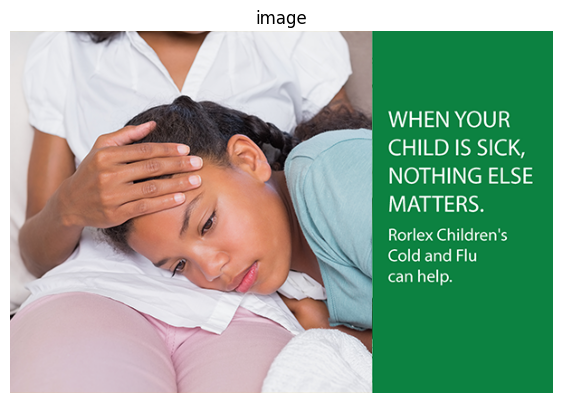

In [4]:
qid = '389'
visualize_qestion_img(qid, problems[qid]['caption'])

In [5]:
choices, gt_answer = problems[qid]["choices"], problems[qid]["answer"]
prompt = build_prompt(problems, shot_qids, qid, prompt_format='QCM-A')
print(f"{'*'*150}\nthe model prompt for qwen:\n{prompt}")

******************************************************************************************************************************************************
the model prompt for qwen:
Question: Does this passage describe the weather or the climate?
The wind was blowing from the west in Ensenada, Mexico, last week.
Context: Hint: Weather is what the atmosphere is like at a certain place and time. Climate is the pattern of weather in a certain place.
Options: (A) climate (B) weather
Answer: The answer is B.

Question: Which is a run-on sentence?
Context: N/A
Options: (A) The little boy popped a big bubble. (B) Nora just moved here, she's new to our country.
Answer: The answer is B.

Question: Which property matches this object?
Context: Select the better answer. The image features a white background with a roll of tin foil on it. The tin foil is positioned in the center of the image, taking up a significant portion of the space. There are also several other items placed around the tin foil, su

In [6]:
response, predict_answer = qwen_predict(prompt)
print(f"model_response:\n {response}")

model_response:
 The answer is B.


In [7]:
choices, gt_answer = problems[qid]["choices"], problems[qid]["answer"]
prompt = build_prompt(problems, shot_qids, qid, prompt_format='QCM-ALE')
print(f"{'*'*150}\nthe model prompt for qwen:\n{prompt}")

******************************************************************************************************************************************************
the model prompt for qwen:
Question: Does this passage describe the weather or the climate?
The wind was blowing from the west in Ensenada, Mexico, last week.
Context: Hint: Weather is what the atmosphere is like at a certain place and time. Climate is the pattern of weather in a certain place.
Options: (A) climate (B) weather
Answer: The answer is B. BECAUSE: The atmosphere is the layer of air that surrounds Earth. Both weather and climate tell you about the atmosphere.\nWeather is what the atmosphere is like at a certain place and time. Weather can change quickly. For example, the temperature outside your house might get higher throughout the day.\nClimate is the pattern of weather in a certain place. For example, summer temperatures in New York are usually higher than winter temperatures. Read the text carefully.\nThe wind was blowing

In [8]:
response, predict_answer = qwen_predict(prompt)
print(f"model_response: {response}\n")

model_response: The answer is B. BECAUSE: Rhetorical appeals are strategies used to persuade an audience. There are three main types: logos, ethos, and pathos.

- Logos (reason) appeals to logic and uses facts, data, or clear reasoning to convince the audience.
- Ethos (character) appeals to credibility or trustworthiness, often showing that the speaker is reliable or knowledgeable.
- Pathos (emotion) appeals to the audience’s feelings, such as love, sadness, fear, or happiness.

In this ad, the image shows a mother holding her daughter closely on a couch, with their heads touching and hands gently placed for comfort. The presence of pillows adds to the sense of warmth and care. Two other people nearby suggest a close-knit family or support system. This scene is designed to evoke feelings of love, safety, and emotional connection.

There are no statistics, logical arguments, or claims about credibility. Instead, the ad focuses on creating an emotional response. Therefore, the primary r

# preparation on multiple questions

In [9]:
def evaluate_on_dataset(prompt_format='CQM-A'):
    result, correct = {}, 0
    for qid in qids:
        choices, gt_answer = problems[qid]["choices"], problems[qid]["answer"]
        prompt = build_prompt(problems, shot_qids, qid, prompt_format='CQM-A')

        response, predict_answer = qwen_predict(prompt)
        pred_idx = get_pred_idx(predict_answer, choices)  # 0, 1, ..., 4
        if pred_idx == gt_answer:
            correct += 1

        result[qid]=copy.deepcopy(problems[qid])   
        result[qid]['predict'], result[qid]['response']=pred_idx, response
    acc = correct/len(result)
    return result, correct, acc

result_a, correct_a, acc_a = evaluate_on_dataset(prompt_format='QCM-A')
result_ale, correct_ale, acc_ale = evaluate_on_dataset(prompt_format='QCM-ALE')

print(f"the acc of format 'QCM-A' is: {acc_a}\nthe acc of format 'QCM-ALE' is: {acc_ale}")

the acc of format 'QCM-A' is: 0.9
the acc of format 'QCM-ALE' is: 1.0
